# Scout models

In this notebook we explore different strategies of using smaller and faster models to produce IH scores and soft labels, which we know from the previous experiments should improve the AP100 metric.

`**Disclaimer** this notebook is a summary of multiple experiments created to present the explorative process. We omited data loading and preprocessing, etc. For full, functioning notebooks see the 'examples' included.`

## 1 x 1:1  ResNet "mini" scout + 1:20 ResNet "small"

Training ResNet "mini" scouts on 1:1 ratio of data subsampled from the main model's (ResNet "small") training dataset.

In [ ]:
def get_soft_labels(df, borders, min_major, ih_col="ih", increase=0.05, defaul_minor=0.95):
  
  # Set default minor label
  df.loc[df[1] == 1, ['s_0', 's_1']] = [0.05, 0.95]

  for i in range(1, len(borders)):
    print(borders[i-1:i+1])
    label_change = min_major + (i-1) * increase
    df.loc[(df[1] == 0) & (df[ih_col] >= borders[i-1]),  ['s_0', 's_1']] = [1. - label_change, 0. + label_change]
  
  # Join s_0 and s_1 into a single column
  df['soft_label'] = df.apply(lambda row: [row['s_0'], row['s_1']], axis=1, result_type="reduce")
  
  del df['s_0']
  del df['s_1']

  return df

In [ ]:
NUM_MODELS = 10
RATIO = 20
SCOUT_RATIO = 1

num_positive = len(train_pool[df['label'] == 1])
total_samples = num_positive * RATIO

for model_num in range(NUM_MODELS):

  print("\n\n\n")
  print("-"*50)
  print(model_num)
  print("-"*50)

  ##############################################################################
  # SCOUT
  ##############################################################################
  
  # Prepare data
  train_data = pd.concat([
      
      train_pool[(df['label'] == 0)].sample(n=num_positive * SCOUT_RATIO, random_state=3167*model_num),
      train_pool[df['label'] == 1].sample(frac=1., replace=False),

      ], axis=0).sample(frac=1.0)[[0, 1]]
  train_data.reset_index(inplace=True)
  del train_data['index']

  # with strategy.scope():

  resnet_mini = create_res_net(name=f"resnet_mini_{model_num}", size="mini")
  resnet_mini.compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.BinaryCrossentropy(),
          "metrics": [precision_, recall_]
      })
  
  # Init callbacks
  callbacks = [

      tf.keras.callbacks.EarlyStopping(
          monitor="val_loss", 
          min_delta=0.001, 
          patience=10, 
          verbose=1, 
          mode="min", 
          baseline=None, 
          restore_best_weights=True
      )
  ]

  history = resnet_mini.fit(
    x=np.array(list(train_data[0])), 
    y=np.array(list(train_data[1])), 

    shuffle=True,
    batch_size=128, # CHANGE BASED ON RATIO!
    validation_split=0.05,

    verbose=1,
    epochs=1000,
    callbacks=callbacks
  )

  resnet_mini.save(f"{dir_path}/models/scouts/rm_hist_{SCOUT_RATIO}_{model_num}.h5")
  
  # resnet_mini = tf.keras.models.load_model(f"{dir_path}/models/scouts/rm_20_{model_num}.h5", custom_objects={"recall_": recall_, "precision_": precision_})

  # print("Scout results:")
  # test_and_plot([resnet_mini], test_data_1, test_data_10, test_data_100, combine_method=None)

  # # Generate IH scores for samples
  train_pool[f'ih_scout_{model_num}'] = get_instances_hardness(resnet_mini, train_pool, data_col=0, label_col=1, batch_size=100000)  

  ##############################################################################
  # Model
  ##############################################################################

  # Get new training data for ResNet "small"
  train_data_hard = train_pool[(train_pool[1] == 0) & (train_pool[f'ih_scout_{model_num}'] > 0.25)].sample(n=min(100000, len(train_pool[(train_pool[1] == 0) & (train_pool[f'ih_scout_{model_num}'] > 0.1)])))
  train_data = pd.concat([

      train_data_hard,

      train_pool[(df['label'] == 0)].sample(n=(total_samples - num_positive - len(train_data_hard)), random_state=3167*model_num),
      train_pool[df['label'] == 1].sample(frac=1., replace=False),

      ], axis=0).sample(frac=1.0)[[0, 1, f'ih_scout_{model_num}']]
  train_data.reset_index(inplace=True)
  del train_data['index']

  '''
  Update labels

  In this experiment just add label smoothing to all samples.
  '''

  borders = []

  label_col = 1
  ih_col = f'ih_scout_{model_num}'

  train_data = get_soft_labels(train_data, np.arange(0.0, 0.7, 0.1), 0.05, ih_col=ih_col, increase=0.05, bins=10, defaul_minor=0.95)

  print(train_data['soft_label'].value_counts())

  # with strategy.scope():
  rs = create_res_net(name=f"resnet_small_{model_num}", size="small", output="softmax")
  rs.compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.CategoricalCrossentropy(),
          "metrics": []
      })

  # Init callbacks
  callbacks = [

      tf.keras.callbacks.EarlyStopping(
          monitor="val_loss", 
          min_delta=0.0001, 
          patience=15, 
          verbose=1, 
          mode="min", 
          baseline=None, 
          restore_best_weights=True
      )

      # tf.keras.callbacks.ModelCheckpoint(f"./models/model_1_100.h5", save_best_only=True, verbose=0)
  ]

  history = rs.fit(
      x=np.array(list(train_data[0])), 
      y=np.array(list(train_data['soft_label'])), 

      shuffle=True,
      batch_size=128*8,
      validation_split=0.05,

      verbose=1,
      epochs=1000,
      callbacks=callbacks
      )

  # plot_training(history)

  rs.save(f"{dir_path}/models/scouts/rs_hist_{SCOUT_RATIO}_{model_num}.h5")





--------------------------------------------------
0
--------------------------------------------------
Epoch 1/1000
229/229 [==============================] - 11s 34ms/step - loss: 0.6217 - precision_: 0.6580 - recall_: 0.6408 - val_loss: 1.4566 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
229/229 [==============================] - 7s 32ms/step - loss: 0.4926 - precision_: 0.7842 - recall_: 0.7504 - val_loss: 0.7258 - val_precision_: 0.9681 - val_recall_: 0.4657
Epoch 3/1000
229/229 [==============================] - 7s 31ms/step - loss: 0.4547 - precision_: 0.8152 - recall_: 0.7687 - val_loss: 0.9908 - val_precision_: 0.9779 - val_recall_: 0.3637
Epoch 4/1000
229/229 [==============================] - 7s 31ms/step - loss: 0.4381 - precision_: 0.8228 - recall_: 0.7781 - val_loss: 1.2320 - val_precision_: 0.9818 - val_recall_: 0.2216
Epoch 5/1000
229/229 [==============================] - 7s 31ms/step - loss: 0.4212 - precision_: 0.8329 - recall_: 0.7881 - va

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 2s 45ms/step
[0.  0.1]
[0.1 0.2]
[0.2 0.3]
[0.3 0.4]
[0.4 0.5]
[0.5 0.6]
[0.95, 0.05]                   131521
[0.7, 0.3]                      75220
[0.8, 0.2]                      24947
[0.85, 0.15000000000000002]     22247
[0.75, 0.25]                    19480
[0.9, 0.1]                      19033
[0.05, 0.95]                    15392
Name: soft_label, dtype: int64
Epoch 1/1000
286/286 [==============================] - 110s 374ms/step - loss: 0.4804 - val_loss: 0.8835
Epoch 2/1000
286/286 [==============================] - 107s 374ms/step - loss: 0.4540 - val_loss: 0.5976
Epoch 3/1000
286/286 [==============================] - 107s 374ms/step - loss: 0.4462 - val_loss: 0.4936
Epoch 4/1000
286/286 [==============================] - 107s 374ms/step - loss: 0.4354 - val_loss: 0.4329
Epoch 5/1000
286/286 [==============================] - 107s 374ms/step - loss: 0.4237 - val_loss: 0.4293
Epoch 6/1000
286/286 [==============================] - 107

  0%|          | 0/16 [00:00<?, ?it/s]

57/98 [================>.............] - ETA: 5s

AP100 = 0.5326719711906921
AP10 = 0.8288871825017242
AP1 = 0.9690190180669812


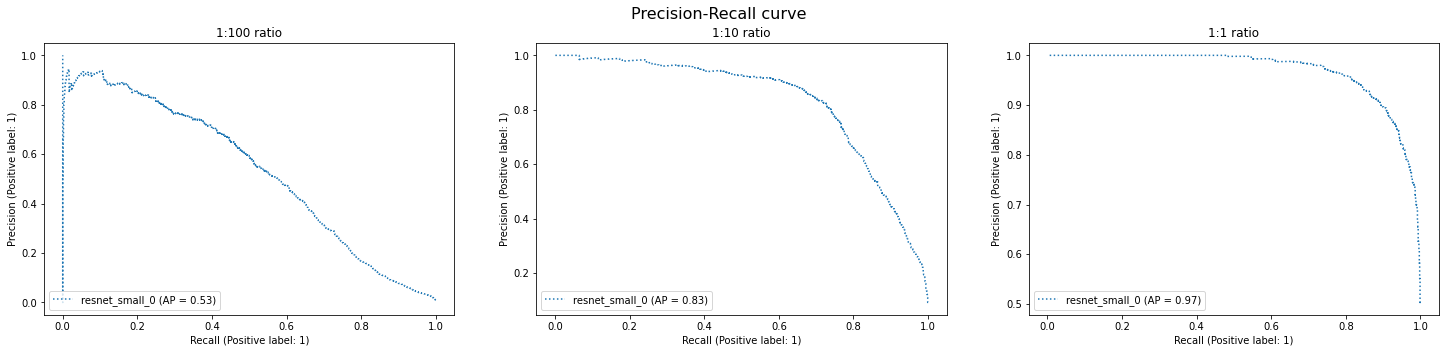

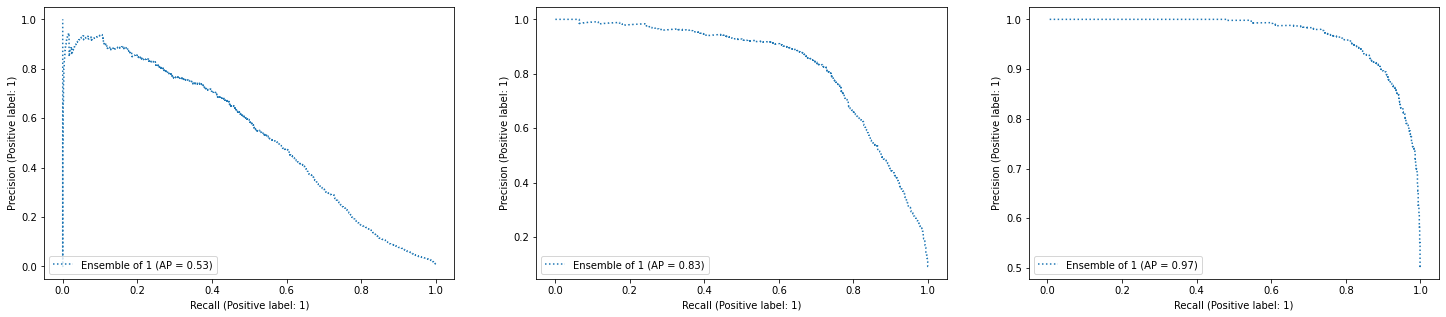

In [ ]:
models = [tf.keras.models.load_model(f"{dir_path}/models/scouts/rs_hist_{SCOUT_RATIO}_{model_num}.h5", custom_objects={"precision_": precision_, "recall_": recall_}) for model_num in range(NUM_MODELS)]

test_and_plot_softmax(models, test_data_1, test_data_10, test_data_100, combine_method="mean")

In [ ]:
save_predictions(models, test_data_1, test_data_10, test_data_100)

## 1 x 1:20 ResNet "mini" scout + 1:20 ResNet "small"

Training "smarter" ResNet "mini" scouts on 1:20 ratio of data from the main model's (ResNet "small") training dataset.

In [ ]:
def get_soft_labels(df, borders, min_major, ih_col="ih", increase=0.05, defaul_minor=0.95):
  
  # Set default minor label
  df.loc[df[1] == 1, ['s_0', 's_1']] = [1-defaul_minor, defaul_minor]

  for i in range(1, len(borders)):
    print(borders[i-1:i+1])
    label_change = min_major + (i-1) * increase
    df.loc[(df[1] == 0) & (df[ih_col] >= borders[i-1]),  ['s_0', 's_1']] = [1. - label_change, 0. + label_change]
  
  # Join s_0 and s_1 into a single column
  df['soft_label'] = df.apply(lambda row: [row['s_0'], row['s_1']], axis=1, result_type="reduce")
  
  del df['s_0']
  del df['s_1']

  return df

In [ ]:
# Prepare undersampled data

NUM_MODELS = 10
RATIO = 20
SCOUT_RATIO = 20

num_positive = len(train_pool[df['label'] == 1])
total_samples = num_positive * RATIO

for model_num in range(3,NUM_MODELS):

  print("\n\n\n")
  print("-"*50)
  print(model_num)
  print("-"*50)

  ##############################################################################
  # SCOUT
  ##############################################################################
  
  # Prepare data
  train_data = pd.concat([
      
      train_pool[(df['label'] == 0)].sample(n=num_positive * SCOUT_RATIO, random_state=3167*model_num),
      train_pool[df['label'] == 1].sample(frac=1., replace=False),

      ], axis=0).sample(frac=1.0)[[0, 1]]
  train_data.reset_index(inplace=True)
  del train_data['index']

  with strategy.scope():

    resnet_mini = create_res_net(name=f"resnet_mini_{model_num}", size="mini")
    resnet_mini.compile(**{
            "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
            "loss": tf.keras.losses.BinaryCrossentropy(),
            "metrics": [precision_, recall_]
        })
  
  # Init callbacks
  callbacks = [

      tf.keras.callbacks.EarlyStopping(
          monitor="val_loss", 
          min_delta=0.001, 
          patience=15, 
          verbose=1, 
          mode="min", 
          baseline=None, 
          restore_best_weights=True
      )
  ]

  history = resnet_mini.fit(
    x=np.array(list(train_data[0])), 
    y=np.array(list(train_data[1])), 

    shuffle=True,
    batch_size=128*8, # CHANGE BASED ON RATIO!
    validation_split=0.05,

    verbose=1,
    epochs=1000,
    callbacks=callbacks
  )

  resnet_mini.save(f"{dir_path}/models/scouts/rm_softmax_hist_{SCOUT_RATIO}_{model_num}.h5")
  
  # resnet_mini = tf.keras.models.load_model(f"{dir_path}/models/scouts/rm_20_{model_num}.h5", custom_objects={"recall_": recall_, "precision_": precision_})

  # print("Scout results:")
  # test_and_plot([resnet_mini], test_data_1, test_data_10, test_data_100, combine_method=None)

  # # Generate IH scores for samples
  train_pool[f'ih_scout_{model_num}'] = get_instances_hardness(resnet_mini, train_pool, data_col=0, label_col=1, batch_size=100000)  

  ##############################################################################
  # Model
  ##############################################################################

  # Get new training data for ResNet "small"
  train_data_hard = train_pool[(train_pool[1] == 0) & (train_pool[f'ih_scout_{model_num}'] > 0.1)].sample(n=min(100000, len(train_pool[(train_pool[1] == 0) & (train_pool[f'ih_scout_{model_num}'] > 0.1)])))
  train_data = pd.concat([

      train_data_hard,

      train_pool[(df['label'] == 0)].sample(n=(total_samples - num_positive - len(train_data_hard)), random_state=3167*model_num),
      train_pool[df['label'] == 1].sample(frac=1., replace=False),

      ], axis=0).sample(frac=1.0)[[0, 1, f'ih_scout_{model_num}']]
  train_data.reset_index(inplace=True)
  del train_data['index']

  '''
  Update labels

  Use precise label smoothing.. We assume that a scout trained on 1:20 ratio should be smart enough.
  '''

  label_col = 1
  ih_col = f'ih_scout_{model_num}'

  train_data = get_soft_labels(train_data, np.arange(0.0, 1.1, 0.1), 0.05, ih_col=ih_col, increase=0.05, defaul_minor=0.95)

  print(train_data['soft_label'].value_counts())

  with strategy.scope():
    rs = create_res_net(name=f"resnet_small_{model_num}", size="small", output="softmax")
    rs.compile(**{
            "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
            "loss": tf.keras.losses.CategoricalCrossentropy(),
            "metrics": []
        })

  # Init callbacks
  callbacks = [

      tf.keras.callbacks.EarlyStopping(
          monitor="val_loss", 
          min_delta=0.0001, 
          patience=30, 
          verbose=1, 
          mode="min", 
          baseline=None, 
          restore_best_weights=True
      )

      # tf.keras.callbacks.ModelCheckpoint(f"./models/model_1_100.h5", save_best_only=True, verbose=0)
  ]

  history = rs.fit(
      x=np.array(list(train_data[0])), 
      y=np.array(list(train_data['soft_label'])), 

      shuffle=True,
      batch_size=128*8,
      validation_split=0.05,

      verbose=1,
      epochs=1000,
      callbacks=callbacks
      )

  # plot_training(history)

  rs.save(f"{dir_path}/models/scouts/rs_softmax_hist_{SCOUT_RATIO}_{model_num}.h5")





--------------------------------------------------
3
--------------------------------------------------
Epoch 1/1000
300/300 [==============================] - 48s 87ms/step - loss: 0.2522 - precision_: 0.0339 - recall_: 0.0374 - val_loss: 0.2079 - val_precision_: 0.0625 - val_recall_: 0.0085
Epoch 2/1000
300/300 [==============================] - 11s 35ms/step - loss: 0.1470 - precision_: 0.4455 - recall_: 0.1529 - val_loss: 0.1253 - val_precision_: 0.6534 - val_recall_: 0.3234
Epoch 3/1000
300/300 [==============================] - 10s 33ms/step - loss: 0.1399 - precision_: 0.5646 - recall_: 0.2498 - val_loss: 0.2635 - val_precision_: 0.3437 - val_recall_: 0.0665
Epoch 4/1000
300/300 [==============================] - 10s 33ms/step - loss: 0.1297 - precision_: 0.6070 - recall_: 0.2902 - val_loss: 0.1285 - val_precision_: 0.6726 - val_recall_: 0.2392
Epoch 5/1000
300/300 [==============================] - 10s 33ms/step - loss: 0.1251 - precision_: 0.6301 - recall_: 0.3266 - val_lo

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 51ms/step
[0.  0.1]
[0.1 0.2]
[0.2 0.3]
[0.3 0.4]
[0.4 0.5]
[0.5 0.6]
[0.6 0.7]
[0.7 0.8]
[0.8 0.9]
[0.9 1. ]
[0.95, 0.05]                                 209919
[0.9, 0.1]                                    37948
[0.85, 0.15000000000000002]                   16395
[0.05, 0.95]                                  15392
[0.8, 0.2]                                     9332
[0.75, 0.25]                                   5941
[0.7, 0.3]                                     3945
[0.6499999999999999, 0.35000000000000003]      2832
[0.6, 0.4]                                     2371
[0.55, 0.45]                                   2105
[0.5, 0.5]                                     1660
Name: soft_label, dtype: int64
Epoch 1/1000
286/286 [==============================] - 49s 95ms/step - loss: 0.3783 - val_loss: 0.4414
Epoch 2/1000
286/286 [==============================] - 12s 40ms/step - loss: 0.3495 - val_loss: 0.4190
Epoch 3/1000
286/286 [=============

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 54ms/step
[0.  0.1]
[0.1 0.2]
[0.2 0.3]
[0.3 0.4]
[0.4 0.5]
[0.5 0.6]
[0.6 0.7]
[0.7 0.8]
[0.8 0.9]
[0.9 1. ]
[0.95, 0.05]                                 198550
[0.9, 0.1]                                    40436
[0.85, 0.15000000000000002]                   19125
[0.05, 0.95]                                  15392
[0.8, 0.2]                                    10443
[0.75, 0.25]                                   6741
[0.7, 0.3]                                     5074
[0.6499999999999999, 0.35000000000000003]      4113
[0.6, 0.4]                                     3285
[0.55, 0.45]                                   2822
[0.5, 0.5]                                     1859
Name: soft_label, dtype: int64
Epoch 1/1000
286/286 [==============================] - 49s 95ms/step - loss: 0.3934 - val_loss: 0.4623
Epoch 2/1000
286/286 [==============================] - 12s 41ms/step - loss: 0.3631 - val_loss: 0.3901
Epoch 3/1000
286/286 [=============

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 53ms/step
[0.  0.1]
[0.1 0.2]
[0.2 0.3]
[0.3 0.4]
[0.4 0.5]
[0.5 0.6]
[0.6 0.7]
[0.7 0.8]
[0.8 0.9]
[0.9 1. ]
[0.95, 0.05]                                 201868
[0.9, 0.1]                                    41016
[0.05, 0.95]                                  15392
[0.85, 0.15000000000000002]                   14956
[0.8, 0.2]                                     9070
[0.75, 0.25]                                   6485
[0.7, 0.3]                                     5045
[0.6499999999999999, 0.35000000000000003]      4366
[0.6, 0.4]                                     3860
[0.55, 0.45]                                   3668
[0.5, 0.5]                                     2114
Name: soft_label, dtype: int64
Epoch 1/1000
286/286 [==============================] - 52s 97ms/step - loss: 0.3922 - val_loss: 0.5067
Epoch 2/1000
286/286 [==============================] - 12s 41ms/step - loss: 0.3592 - val_loss: 0.3687
Epoch 3/1000
286/286 [=============

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 53ms/step
[0.  0.1]
[0.1 0.2]
[0.2 0.3]
[0.3 0.4]
[0.4 0.5]
[0.5 0.6]
[0.6 0.7]
[0.7 0.8]
[0.8 0.9]
[0.9 1. ]
[0.95, 0.05]                                 206545
[0.9, 0.1]                                    36951
[0.85, 0.15000000000000002]                   16171
[0.05, 0.95]                                  15392
[0.8, 0.2]                                    10012
[0.75, 0.25]                                   7252
[0.7, 0.3]                                     5046
[0.6499999999999999, 0.35000000000000003]      3802
[0.6, 0.4]                                     3015
[0.55, 0.45]                                   2352
[0.5, 0.5]                                     1302
Name: soft_label, dtype: int64
Epoch 1/1000
286/286 [==============================] - 50s 96ms/step - loss: 0.3806 - val_loss: 0.4763
Epoch 2/1000
286/286 [==============================] - 12s 41ms/step - loss: 0.3543 - val_loss: 0.4021
Epoch 3/1000
286/286 [=============

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 56ms/step
[0.  0.1]
[0.1 0.2]
[0.2 0.3]
[0.3 0.4]
[0.4 0.5]
[0.5 0.6]
[0.6 0.7]
[0.7 0.8]
[0.8 0.9]
[0.9 1. ]
[0.95, 0.05]                                 191631
[0.9, 0.1]                                    40912
[0.85, 0.15000000000000002]                   17644
[0.05, 0.95]                                  15392
[0.8, 0.2]                                    10997
[0.75, 0.25]                                   8081
[0.7, 0.3]                                     6580
[0.6499999999999999, 0.35000000000000003]      5442
[0.6, 0.4]                                     4795
[0.55, 0.45]                                   4037
[0.5, 0.5]                                     2329
Name: soft_label, dtype: int64
Epoch 1/1000
286/286 [==============================] - 51s 98ms/step - loss: 0.4033 - val_loss: 0.5652
Epoch 2/1000
286/286 [==============================] - 12s 42ms/step - loss: 0.3735 - val_loss: 0.4344
Epoch 3/1000
286/286 [=============

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 52ms/step
[0.  0.1]
[0.1 0.2]
[0.2 0.3]
[0.3 0.4]
[0.4 0.5]
[0.5 0.6]
[0.6 0.7]
[0.7 0.8]
[0.8 0.9]
[0.9 1. ]
[0.95, 0.05]                                 222995
[0.9, 0.1]                                    29829
[0.05, 0.95]                                  15392
[0.85, 0.15000000000000002]                   13046
[0.8, 0.2]                                     7836
[0.75, 0.25]                                   5560
[0.7, 0.3]                                     4161
[0.6499999999999999, 0.35000000000000003]      3165
[0.6, 0.4]                                     2628
[0.55, 0.45]                                   2174
[0.5, 0.5]                                     1054
Name: soft_label, dtype: int64
Epoch 1/1000
286/286 [==============================] - 52s 98ms/step - loss: 0.3746 - val_loss: 0.3842
Epoch 2/1000
286/286 [==============================] - 11s 38ms/step - loss: 0.3454 - val_loss: 0.4129
Epoch 3/1000
286/286 [=============

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 55ms/step
[0.  0.1]
[0.1 0.2]
[0.2 0.3]
[0.3 0.4]
[0.4 0.5]
[0.5 0.6]
[0.6 0.7]
[0.7 0.8]
[0.8 0.9]
[0.9 1. ]
[0.95, 0.05]                                 212637
[0.9, 0.1]                                    39992
[0.05, 0.95]                                  15392
[0.85, 0.15000000000000002]                   14346
[0.8, 0.2]                                     7810
[0.75, 0.25]                                   5085
[0.7, 0.3]                                     3743
[0.6499999999999999, 0.35000000000000003]      2877
[0.6, 0.4]                                     2334
[0.55, 0.45]                                   2020
[0.5, 0.5]                                     1604
Name: soft_label, dtype: int64
Epoch 1/1000
286/286 [==============================] - 52s 100ms/step - loss: 0.3709 - val_loss: 0.4455
Epoch 2/1000
286/286 [==============================] - 12s 41ms/step - loss: 0.3441 - val_loss: 0.3916
Epoch 3/1000
286/286 [============

Model resnet_small_3
AP100 = 0.540616022937116
AP10 = 0.8299173002187971
AP1 = 0.9699295794768664
Model resnet_small_4
AP100 = 0.5283714050475079
AP10 = 0.8266232934692015
AP1 = 0.9701825791564415
Model resnet_small_5
AP100 = 0.5342232240057301
AP10 = 0.828207384647434
AP1 = 0.9731420752329766
Model resnet_small_6
AP100 = 0.5303217668560958
AP10 = 0.8306739019946126
AP1 = 0.9677827521272535
Model resnet_small_7
AP100 = 0.5254394949225712
AP10 = 0.8247726786700011
AP1 = 0.9708705201901837
Model resnet_small_8
AP100 = 0.5330860798312645
AP10 = 0.8330642087473679
AP1 = 0.9704651949782382
Model resnet_small_9
AP100 = 0.5154007248647827
AP10 = 0.8269658242027156
AP1 = 0.9712423088365993


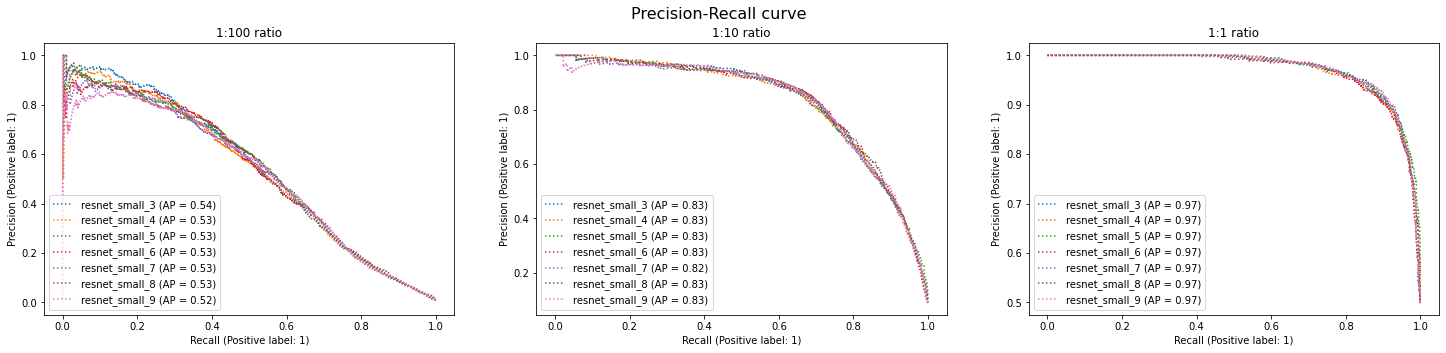

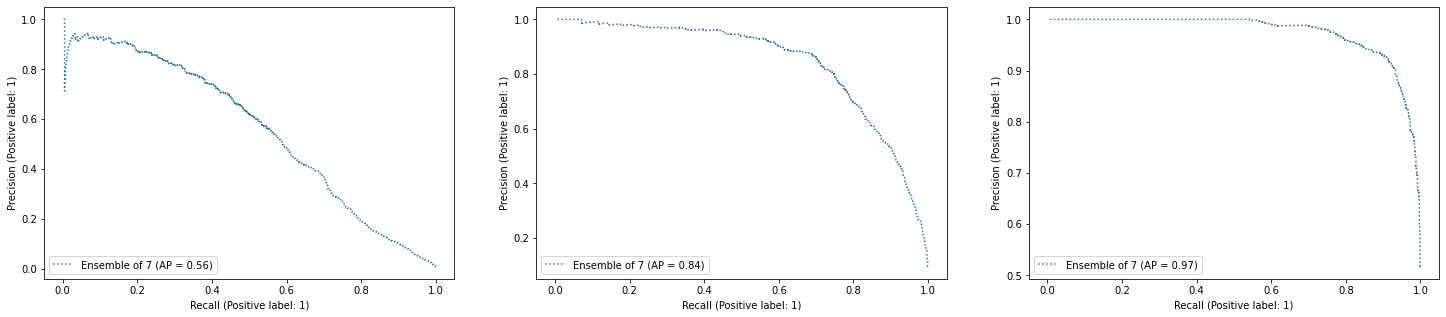

In [ ]:
with strategy.scope():
  models = [tf.keras.models.load_model(f"{dir_path}/models/scouts/rs_softmax_hist_{SCOUT_RATIO}_{model_num}.h5") for model_num in range(3, NUM_MODELS)]

test_and_plot_softmax(models, test_data_1, test_data_10, test_data_100, combine_method="mean")

In [ ]:
save_predictions(models, test_data_1, test_data_10, test_data_100)

## 5 x 1:1 ResNet "mini" scout + 1:20 ResNet "small"

Trying out an ensemble of mini scout models.





--------------------------------------------------
0
--------------------------------------------------
Epoch 1/1000
115/115 [==============================] - 8s 48ms/step - loss: 0.6550 - precision_: 0.6009 - recall_: 0.6068 - val_loss: 1.3720 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
115/115 [==============================] - 5s 44ms/step - loss: 0.5452 - precision_: 0.7303 - recall_: 0.7220 - val_loss: 1.8087 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 3/1000
115/115 [==============================] - 5s 45ms/step - loss: 0.4755 - precision_: 0.7974 - recall_: 0.7528 - val_loss: 0.9556 - val_precision_: 0.9814 - val_recall_: 0.4016
Epoch 4/1000
115/115 [==============================] - 5s 45ms/step - loss: 0.4410 - precision_: 0.8203 - recall_: 0.7714 - val_loss: 0.7050 - val_precision_: 0.9614 - val_recall_: 0.6052
Epoch 5/1000
115/115 [==============================] - 5s 44ms/step - loss: 0.4217 - precision_: 0.8337 - recall_: 0.78

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 63ms/step
Epoch 1/1000
115/115 [==============================] - 12s 83ms/step - loss: 0.6119 - precision_: 0.6645 - recall_: 0.6416 - val_loss: 1.3058 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4922 - precision_: 0.7843 - recall_: 0.7441 - val_loss: 1.4911 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 3/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4571 - precision_: 0.8146 - recall_: 0.7583 - val_loss: 1.6709 - val_precision_: 0.7143 - val_recall_: 0.0092
Epoch 4/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4341 - precision_: 0.8294 - recall_: 0.7691 - val_loss: 0.9914 - val_precision_: 0.9898 - val_recall_: 0.1736
Epoch 5/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4202 - precision_: 0.8382 - recall_: 0.7791 - val_loss: 0.9957 - val_precision_: 0.9921 - val_

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 64ms/step
Epoch 1/1000
115/115 [==============================] - 12s 82ms/step - loss: 0.6644 - precision_: 0.5939 - recall_: 0.5828 - val_loss: 1.2578 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.5584 - precision_: 0.7204 - recall_: 0.7113 - val_loss: 1.3508 - val_precision_: 0.8147 - val_recall_: 0.0905
Epoch 3/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4771 - precision_: 0.7958 - recall_: 0.7572 - val_loss: 0.8633 - val_precision_: 0.8238 - val_recall_: 0.3722
Epoch 4/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4393 - precision_: 0.8247 - recall_: 0.7757 - val_loss: 0.6515 - val_precision_: 0.8253 - val_recall_: 0.4804
Epoch 5/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4195 - precision_: 0.8361 - recall_: 0.7823 - val_loss: 0.6606 - val_precision_: 0.8327 - val_recall_:

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 63ms/step
Epoch 1/1000
115/115 [==============================] - 12s 83ms/step - loss: 0.6538 - precision_: 0.6072 - recall_: 0.5870 - val_loss: 1.1693 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.5056 - precision_: 0.7734 - recall_: 0.7354 - val_loss: 2.1620 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 3/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4657 - precision_: 0.8043 - recall_: 0.7542 - val_loss: 1.4176 - val_precision_: 0.7143 - val_recall_: 0.0264
Epoch 4/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4464 - precision_: 0.8199 - recall_: 0.7653 - val_loss: 1.0141 - val_precision_: 0.9837 - val_recall_: 0.3277
Epoch 5/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4269 - precision_: 0.8322 - recall_: 0.7778 - val_loss: 0.5736 - val_precision_: 0.9710 - val_

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 63ms/step
Epoch 1/1000
115/115 [==============================] - 12s 83ms/step - loss: 0.6337 - precision_: 0.6420 - recall_: 0.6121 - val_loss: 1.3990 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.5410 - precision_: 0.7377 - recall_: 0.7206 - val_loss: 1.5142 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 3/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4646 - precision_: 0.8014 - recall_: 0.7636 - val_loss: 1.4611 - val_precision_: 0.8452 - val_recall_: 0.0806
Epoch 4/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4323 - precision_: 0.8315 - recall_: 0.7702 - val_loss: 0.7512 - val_precision_: 0.9615 - val_recall_: 0.5451
Epoch 5/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4136 - precision_: 0.8369 - recall_: 0.7912 - val_loss: 0.6961 - val_precision_: 0.9669 - val_

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 63ms/step
0.05    168845
0.10     72461
0.15     17743
0.95     16253
0.20     16041
0.30      8512
0.25      7985
Name: soft_label, dtype: int64
Epoch 1/1000
286/286 [==============================] - 126s 434ms/step - loss: 0.3862 - precision_: 0.2759 - recall_: 0.0296 - val_loss: 0.5349 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
286/286 [==============================] - 123s 432ms/step - loss: 0.3642 - precision_: 0.5136 - recall_: 0.1414 - val_loss: 0.4375 - val_precision_: 0.6875 - val_recall_: 0.0527
Epoch 3/1000
286/286 [==============================] - 123s 432ms/step - loss: 0.3559 - precision_: 0.5492 - recall_: 0.2335 - val_loss: 0.3715 - val_precision_: 0.7650 - val_recall_: 0.2049
Epoch 4/1000
286/286 [==============================] - 123s 432ms/step - loss: 0.3491 - precision_: 0.5759 - recall_: 0.3036 - val_loss: 0.3484 - val_precision_: 0.6164 - val_recall_: 0.3623
Epoch 5/1000
286/286 [============

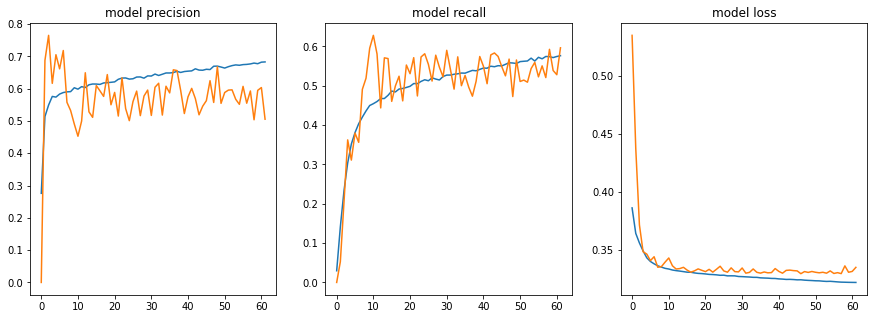





--------------------------------------------------
1
--------------------------------------------------
Epoch 1/1000
115/115 [==============================] - 12s 83ms/step - loss: 0.6254 - precision_: 0.6446 - recall_: 0.6524 - val_loss: 1.1300 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4857 - precision_: 0.7896 - recall_: 0.7560 - val_loss: 2.0654 - val_precision_: 0.1429 - val_recall_: 0.0012
Epoch 3/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4517 - precision_: 0.8163 - recall_: 0.7686 - val_loss: 0.9364 - val_precision_: 0.8357 - val_recall_: 0.2250
Epoch 4/1000
115/115 [==============================] - 9s 79ms/step - loss: 0.4367 - precision_: 0.8227 - recall_: 0.7745 - val_loss: 0.6062 - val_precision_: 0.9466 - val_recall_: 0.6288
Epoch 5/1000
115/115 [==============================] - 9s 79ms/step - loss: 0.4201 - precision_: 0.8304 - recall_: 0.7862 - va

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 63ms/step
Epoch 1/1000
115/115 [==============================] - 12s 82ms/step - loss: 0.6632 - precision_: 0.5952 - recall_: 0.5958 - val_loss: 1.2907 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.5131 - precision_: 0.7678 - recall_: 0.7388 - val_loss: 1.5732 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 3/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4640 - precision_: 0.8069 - recall_: 0.7600 - val_loss: 1.4188 - val_precision_: 0.5714 - val_recall_: 0.0207
Epoch 4/1000
115/115 [==============================] - 9s 79ms/step - loss: 0.4389 - precision_: 0.8258 - recall_: 0.7724 - val_loss: 1.0540 - val_precision_: 0.8571 - val_recall_: 0.1388
Epoch 5/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4244 - precision_: 0.8356 - recall_: 0.7769 - val_loss: 0.6704 - val_precision_: 0.8280 - val_

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 63ms/step
Epoch 1/1000
115/115 [==============================] - 12s 82ms/step - loss: 0.6460 - precision_: 0.6314 - recall_: 0.5976 - val_loss: 1.1847 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.5092 - precision_: 0.7683 - recall_: 0.7402 - val_loss: 1.5098 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 3/1000
115/115 [==============================] - 9s 77ms/step - loss: 0.4628 - precision_: 0.8095 - recall_: 0.7594 - val_loss: 1.2029 - val_precision_: 0.8175 - val_recall_: 0.0478
Epoch 4/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4381 - precision_: 0.8217 - recall_: 0.7767 - val_loss: 0.7018 - val_precision_: 0.8218 - val_recall_: 0.4224
Epoch 5/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4233 - precision_: 0.8303 - recall_: 0.7882 - val_loss: 0.5796 - val_precision_: 0.9514 - val_

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 63ms/step
Epoch 1/1000
115/115 [==============================] - 12s 82ms/step - loss: 0.6320 - precision_: 0.6494 - recall_: 0.6007 - val_loss: 1.6177 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.5362 - precision_: 0.7349 - recall_: 0.7383 - val_loss: 2.1204 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 3/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4706 - precision_: 0.7976 - recall_: 0.7590 - val_loss: 1.4774 - val_precision_: 0.8286 - val_recall_: 0.0396
Epoch 4/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4494 - precision_: 0.8151 - recall_: 0.7684 - val_loss: 1.1212 - val_precision_: 0.9785 - val_recall_: 0.3863
Epoch 5/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4364 - precision_: 0.8205 - recall_: 0.7764 - val_loss: 0.7938 - val_precision_: 0.9838 - val_

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 63ms/step
Epoch 1/1000
115/115 [==============================] - 14s 83ms/step - loss: 0.6349 - precision_: 0.6347 - recall_: 0.6223 - val_loss: 1.2918 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4903 - precision_: 0.7837 - recall_: 0.7540 - val_loss: 1.3685 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 3/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4521 - precision_: 0.8188 - recall_: 0.7674 - val_loss: 1.3976 - val_precision_: 0.5714 - val_recall_: 0.0057
Epoch 4/1000
115/115 [==============================] - 9s 79ms/step - loss: 0.4296 - precision_: 0.8297 - recall_: 0.7804 - val_loss: 0.8902 - val_precision_: 0.8386 - val_recall_: 0.2311
Epoch 5/1000
115/115 [==============================] - 9s 79ms/step - loss: 0.4082 - precision_: 0.8417 - recall_: 0.7948 - val_loss: 0.6913 - val_precision_: 0.9783 - val_

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 63ms/step
0.05    171360
0.10     73144
0.15     17297
0.95     16403
0.20     14463
0.30      7877
0.25      7296
Name: soft_label, dtype: int64
Epoch 1/1000
286/286 [==============================] - 127s 434ms/step - loss: 0.3912 - precision_: 0.1157 - recall_: 0.0093 - val_loss: 0.4643 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
286/286 [==============================] - 124s 432ms/step - loss: 0.3650 - precision_: 0.4905 - recall_: 0.1047 - val_loss: 0.3845 - val_precision_: 0.5415 - val_recall_: 0.1443
Epoch 3/1000
286/286 [==============================] - 124s 432ms/step - loss: 0.3567 - precision_: 0.5379 - recall_: 0.1888 - val_loss: 0.3491 - val_precision_: 0.4340 - val_recall_: 0.3800
Epoch 4/1000
286/286 [==============================] - 124s 432ms/step - loss: 0.3497 - precision_: 0.5671 - recall_: 0.2633 - val_loss: 0.3426 - val_precision_: 0.4779 - val_recall_: 0.3689
Epoch 5/1000
286/286 [============

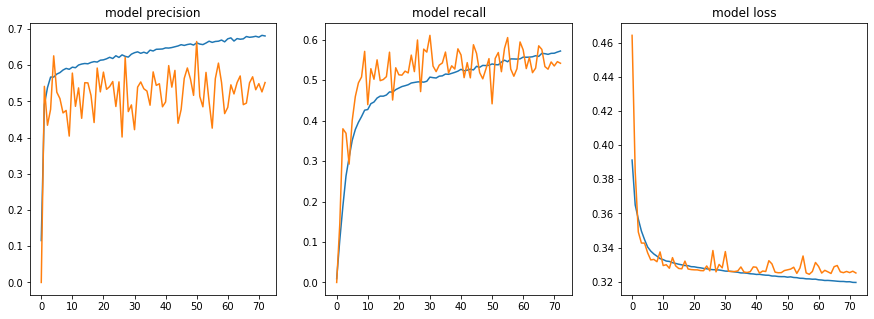





--------------------------------------------------
2
--------------------------------------------------
Epoch 1/1000
115/115 [==============================] - 12s 82ms/step - loss: 0.5656 - precision_: 0.7121 - recall_: 0.7006 - val_loss: 1.1227 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4734 - precision_: 0.7981 - recall_: 0.7608 - val_loss: 1.6331 - val_precision_: 0.1429 - val_recall_: 0.0012
Epoch 3/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4452 - precision_: 0.8215 - recall_: 0.7698 - val_loss: 1.5187 - val_precision_: 0.8571 - val_recall_: 0.0785
Epoch 4/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4315 - precision_: 0.8296 - recall_: 0.7816 - val_loss: 1.3184 - val_precision_: 0.8571 - val_recall_: 0.1201
Epoch 5/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4188 - precision_: 0.8370 - recall_: 0.7893 - va

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 63ms/step
Epoch 1/1000
115/115 [==============================] - 12s 83ms/step - loss: 0.6239 - precision_: 0.6565 - recall_: 0.6321 - val_loss: 1.3240 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4970 - precision_: 0.7812 - recall_: 0.7443 - val_loss: 1.5306 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 3/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4542 - precision_: 0.8137 - recall_: 0.7613 - val_loss: 1.3687 - val_precision_: 0.8571 - val_recall_: 0.0248
Epoch 4/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4342 - precision_: 0.8290 - recall_: 0.7746 - val_loss: 0.8716 - val_precision_: 0.9968 - val_recall_: 0.3501
Epoch 5/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4189 - precision_: 0.8364 - recall_: 0.7837 - val_loss: 0.4438 - val_precision_: 0.9400 - val_

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 64ms/step
Epoch 1/1000
115/115 [==============================] - 14s 86ms/step - loss: 0.6073 - precision_: 0.6571 - recall_: 0.6516 - val_loss: 1.2509 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
115/115 [==============================] - 9s 81ms/step - loss: 0.4872 - precision_: 0.7853 - recall_: 0.7538 - val_loss: 1.5444 - val_precision_: 0.1429 - val_recall_: 0.0023
Epoch 3/1000
115/115 [==============================] - 9s 80ms/step - loss: 0.4462 - precision_: 0.8155 - recall_: 0.7689 - val_loss: 0.9309 - val_precision_: 0.8365 - val_recall_: 0.1589
Epoch 4/1000
115/115 [==============================] - 9s 79ms/step - loss: 0.4270 - precision_: 0.8330 - recall_: 0.7758 - val_loss: 0.5868 - val_precision_: 0.9190 - val_recall_: 0.5234
Epoch 5/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4163 - precision_: 0.8359 - recall_: 0.7909 - val_loss: 0.7304 - val_precision_: 0.9722 - val_recall_:

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 63ms/step
Epoch 1/1000
115/115 [==============================] - 12s 83ms/step - loss: 0.6648 - precision_: 0.6044 - recall_: 0.5629 - val_loss: 1.0064 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.5342 - precision_: 0.7399 - recall_: 0.7338 - val_loss: 1.5081 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 3/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4704 - precision_: 0.8034 - recall_: 0.7625 - val_loss: 1.0872 - val_precision_: 0.8470 - val_recall_: 0.2099
Epoch 4/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4409 - precision_: 0.8265 - recall_: 0.7735 - val_loss: 0.5570 - val_precision_: 0.8141 - val_recall_: 0.5221
Epoch 5/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4268 - precision_: 0.8321 - recall_: 0.7830 - val_loss: 0.4311 - val_precision_: 0.8066 - val_

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 63ms/step
Epoch 1/1000
115/115 [==============================] - 12s 82ms/step - loss: 0.6334 - precision_: 0.6535 - recall_: 0.6153 - val_loss: 0.9572 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.5453 - precision_: 0.7371 - recall_: 0.7169 - val_loss: 1.6170 - val_precision_: 0.2857 - val_recall_: 0.0021
Epoch 3/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4762 - precision_: 0.7948 - recall_: 0.7540 - val_loss: 0.9374 - val_precision_: 0.8474 - val_recall_: 0.2783
Epoch 4/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4510 - precision_: 0.8148 - recall_: 0.7686 - val_loss: 0.7067 - val_precision_: 0.9710 - val_recall_: 0.5031
Epoch 5/1000
115/115 [==============================] - 9s 78ms/step - loss: 0.4312 - precision_: 0.8283 - recall_: 0.7754 - val_loss: 0.6950 - val_precision_: 0.9704 - val_recall_:

  0%|          | 0/16 [00:00<?, ?it/s]

54/54 [==============================] - 3s 63ms/step
0.05    170858
0.10     71783
0.95     16401
0.15     16282
0.20     15289
0.25      8691
0.30      8536
Name: soft_label, dtype: int64
Epoch 1/1000
286/286 [==============================] - 127s 433ms/step - loss: 0.3848 - precision_: 0.2940 - recall_: 0.0344 - val_loss: 0.4968 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
286/286 [==============================] - 123s 432ms/step - loss: 0.3650 - precision_: 0.5060 - recall_: 0.1196 - val_loss: 0.4151 - val_precision_: 0.7182 - val_recall_: 0.0494
Epoch 3/1000
286/286 [==============================] - 124s 432ms/step - loss: 0.3578 - precision_: 0.5435 - recall_: 0.1951 - val_loss: 0.3828 - val_precision_: 0.7750 - val_recall_: 0.1079
Epoch 4/1000
286/286 [==============================] - 123s 432ms/step - loss: 0.3506 - precision_: 0.5555 - recall_: 0.2656 - val_loss: 0.3573 - val_precision_: 0.6494 - val_recall_: 0.2199
Epoch 5/1000
286/286 [============

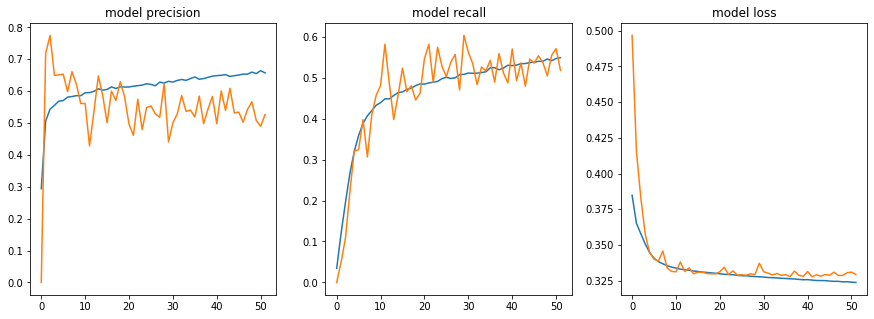





--------------------------------------------------
3
--------------------------------------------------
Epoch 1/1000
115/115 [==============================] - 8s 51ms/step - loss: 0.6858 - precision_: 0.5606 - recall_: 0.5178 - val_loss: 0.9650 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 2/1000
115/115 [==============================] - 5s 44ms/step - loss: 0.5693 - precision_: 0.7065 - recall_: 0.7038 - val_loss: 1.5851 - val_precision_: 0.0000e+00 - val_recall_: 0.0000e+00
Epoch 3/1000
115/115 [==============================] - 5s 45ms/step - loss: 0.4812 - precision_: 0.7976 - recall_: 0.7404 - val_loss: 0.8630 - val_precision_: 0.8308 - val_recall_: 0.2721
Epoch 4/1000
115/115 [==============================] - 5s 45ms/step - loss: 0.4510 - precision_: 0.8202 - recall_: 0.7605 - val_loss: 0.4983 - val_precision_: 0.8733 - val_recall_: 0.6222
Epoch 5/1000
115/115 [==============================] - 5s 45ms/step - loss: 0.4371 - precision_: 0.8251 - recall_: 0.77

  0%|          | 0/16 [00:00<?, ?it/s]

98/98 [==============================] - 3s 33ms/step


KeyboardInterrupt: ignored

In [ ]:
# Prepare undersampled data

NUM_MODELS = 5
NUM_SCOUTS = 5
RATIO = 20
SCOUT_RATIO = 1

num_positive = len(train_pool[df['label'] == 1])
total_samples = num_positive * RATIO

for model_num in range(NUM_MODELS):

  print("\n\n\n")
  print("-"*50)
  print(model_num)
  print("-"*50)

  # Get initial model data
  train_data_init = pd.concat([

      train_pool[df['label'] == 0].sample(n=(total_samples - num_positive), random_state=3167*model_num),
      train_pool[df['label'] == 1].sample(frac=1., replace=False),

  ], axis=0)[[0, 1]]


  ##############################################################################
  # SCOUT
  ##############################################################################

  for num_scout in range(NUM_SCOUTS):
  
    # Prepare data
    train_data = pd.concat([
        
        train_data_init[train_data_init[1] == 0].sample(n=num_positive * SCOUT_RATIO, random_state=3167*model_num*num_scout),
        train_data_init[train_data_init[1] == 1],

        ], axis=0).sample(frac=1.0)[[0, 1]]
    train_data.reset_index(inplace=True)
    del train_data['index']

    # with strategy.scope():

    resnet_mini = create_res_net(name=f"resnet_mini_{model_num}_{num_scout}", size="mini")
    resnet_mini.compile(**{
            "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
            "loss": tf.keras.losses.BinaryCrossentropy(),
            "metrics": [precision_, recall_]
        })
    
    # Init callbacks
    callbacks = [

        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", 
            min_delta=0.001, 
            patience=10, 
            verbose=1, 
            mode="min", 
            baseline=None, 
            restore_best_weights=True
        )
    ]

    history = resnet_mini.fit(
      x=np.array(list(train_data[0])), 
      y=np.array(list(train_data[1])), 

      shuffle=True,
      batch_size=128*2,
      validation_split=0.05,

      verbose=1,
      epochs=1000,
      callbacks=callbacks
    )

    resnet_mini.save(f"{dir_path}/models/scouts/rm_e_{model_num}_{num_scout}.h5")

    # Generate IH scores for samples
    train_pool[f'ih_scout_{model_num}_{num_scout}'] = get_instances_hardness(resnet_mini, train_pool, data_col=0, label_col=1, batch_size=100000)  

  # Compute average IH
  train_pool['ih_mean'] = train_pool[[f'ih_scout_{model_num}_{num_scout}' for num_scout in range(NUM_SCOUTS)]].mean(axis=1)

  ##############################################################################
  # Model
  ##############################################################################

  # Get new training data for ResNet "small"
  train_data_hard = train_pool[train_pool['ih_mean'] > 0.4].sample(n=100000)
  train_data = pd.concat([

      train_data_hard,

      train_pool[(df['label'] == 0)].sample(n=(total_samples - num_positive - len(train_data_hard)), random_state=3167*model_num),
      train_pool[df['label'] == 1].sample(frac=1., replace=False),

      ], axis=0).sample(frac=1.0)[[0, 1, 'ih_mean']]
  train_data.reset_index(inplace=True)
  del train_data['index']

  '''
  Update labels

  In this experiment just add label smoothing to all samples.
  '''

  label_col = 1
  ih_col = 'ih_mean'

  # Add label smoothing to all labels
  train_data.loc[(train_data[label_col] == 0), 'soft_label'] = 0.05
  train_data.loc[train_data[label_col] == 1, 'soft_label'] = 0.95
  for i, base in enumerate([0.40, 0.70, 0.80, 0.90, 0.95]):
    train_data.loc[(train_data[label_col] == 0) & (train_data[ih_col] >= base), 'soft_label'] = 0.10 + 0.05 * i
  
  print(train_data['soft_label'].value_counts())

  # with strategy.scope():
  rs = create_res_net(name=f"resnet_small_{model_num}", size="small")
  rs.compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.BinaryCrossentropy(),
          "metrics": [precision_, recall_]
      })

  # Init callbacks
  callbacks = [

      tf.keras.callbacks.EarlyStopping(
          monitor="val_loss", 
          min_delta=0.0001, 
          patience=15, 
          verbose=1, 
          mode="min", 
          baseline=None, 
          restore_best_weights=True
      )

      # tf.keras.callbacks.ModelCheckpoint(f"./models/model_1_100.h5", save_best_only=True, verbose=0)
  ]

  history = rs.fit(
      x=np.array(list(train_data[0])), 
      y=np.array(list(train_data['soft_label'])), 

      shuffle=True,
      batch_size=128*8,
      validation_split=0.05,

      verbose=1,
      epochs=1000,
      callbacks=callbacks
      )

  plot_training(history)

  rs.save(f"{dir_path}/models/scouts/rs_e_{model_num}.h5")

AP100 = 0.5281837689064074
AP10 = 0.8329671188108437
AP1 = 0.9701549059510497
AP100 = 0.5279121447798434
AP10 = 0.8274810773737701
AP1 = 0.9722280767694069
AP100 = 0.523685156994659
AP10 = 0.8300053083855679
AP1 = 0.9681323815727689


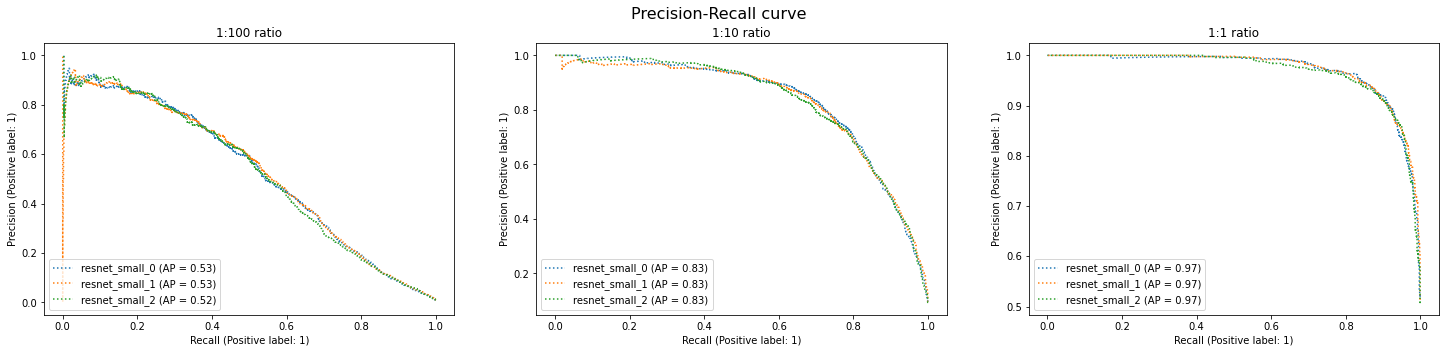

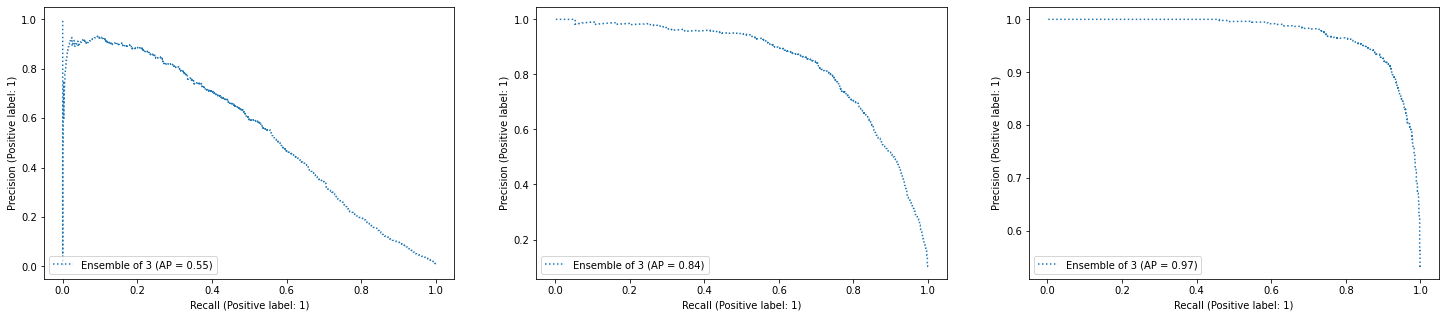

In [ ]:
# with strategy.scope():
models = [tf.keras.models.load_model(f"{dir_path}/models/scouts/rs_e_{model_num}.h5", custom_objects={"precision_": precision_, "recall_": recall_}) for model_num in range(3)]
test_and_plot(models, test_data_1, test_data_10, test_data_100, combine_method="mean")